# Procedure (*** means demonstrated)
1. Data exploration & visualization ***
2. Holdout (splitting data) ***
3. SelectKbest ***
     - gridsearchCV ***
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model ***
         + Cross validation (not sure)
         + Confusion matrix ***
         + Classification_report ***
4. PCA
     - gridsearchCV
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model
         + Cross validation
         + Confusion matrix
         + Classification_report
5. Do the write-up analysis and conclusions, make sure that you include time execution for the models.)

ref:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Part I
selectKbest, Randomforest

### 0. Load data

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [219]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
#     'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    './LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

C:\Users\kefei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [220]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


### 1. EDA
##### data cleaning
- This dataset has 100+ non-null columns, 400,000+ non-null records. 
- For the first atempt, we can just drop all the columns with null values, instead of imputation.
- Note that, the afformentioned strategy is for numerical features; for categorical features, the null values can be handeled by using one-hot-encoding.
- Also note that, in order to make the training set and test set have same features, we will first split the data into training set and test set, then perform one-hot-encoding and dropna.
#### data exploration
- The target is categorical, we are working on classification problem. So, we use bar plot to show the number of each categories. (It might raise some concern if the number of each categories are too unbalanced)
- For each feature, since there are too many, it is very hard to plot them all or analyze individual feature. Later on we will use SelectKbest method for feature engineering.

In [221]:
# 'object' type data info
df_object = y2015.select_dtypes(include=['object'])
print(df_object.info())

# 'float' type data info
df_float = y2015.select_dtypes(include=['float'])
print(df_float.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   id                         421097 non-null  object
 1   term                       421095 non-null  object
 2   int_rate                   421095 non-null  object
 3   grade                      421095 non-null  object
 4   sub_grade                  421095 non-null  object
 5   emp_title                  397221 non-null  object
 6   emp_length                 397278 non-null  object
 7   home_ownership             421095 non-null  object
 8   verification_status        421095 non-null  object
 9   issue_d                    421095 non-null  object
 10  loan_status                421095 non-null  object
 11  pymnt_plan                 421095 non-null  object
 12  url                        421095 non-null  object
 13  desc                       45 non-null      

#### The dataset is kind of big for training, especially for gridsearchCV. For practice purpose, we will cut the data into 10,000 records. 

In [222]:
# cut the data to the first 10,000 records
y2015 = y2015[:10001]
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 8.5+ MB


In [223]:
# Remove two summary rows at the end that don't actually contain data.
# y2015 = y2015[:-2]



# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')


# explore columns with nan falues
null_col_list = []
for col in y2015.columns:
    if y2015[col].isna().any():
        null_col_list.append(col)
        
null_col_list
# len(null_col_list)
y2015[null_col_list].info()

# in this dataset, since we already have a lot of columns, we can drop all the columns with nan instead of imputation.
# df = y2015.drop(null_col_list, axis = 1)
df= y2015.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   emp_title                       9444 non-null   object 
 1   emp_length                      9452 non-null   object 
 2   desc                            1 non-null      object 
 3   title                           9869 non-null   object 
 4   mths_since_last_delinq          5200 non-null   float64
 5   mths_since_last_record          1778 non-null   float64
 6   revol_util                      9996 non-null   object 
 7   last_pymnt_d                    9994 non-null   object 
 8   next_pymnt_d                    8189 non-null   object 
 9   mths_since_last_major_derog     2926 non-null   float64
 10  annual_inc_joint                65 non-null     float64
 11  dti_joint                       65 non-null     float64
 12  verification_status_joint       

In [224]:
# get dummy, but be careful not make too large a dummy dataset, drop those columns with too many categories (>80)
df_object = df.select_dtypes(include='object')
col_drop_list = []
for col in df_object.columns:
#     column = df_object[i]
    print(col)
    print(df_object[col].nunique())
    if df_object[col].nunique() > 80:
        col_drop_list.append(col)
        
# col_drop_list
# type(df_object[i])

df = df.drop(col_drop_list, axis = 1)
df.info()

# # make dummy
# df_dummy = pd.get_dummies(df)
# df_dummy.info()

term
2
grade
7
sub_grade
35
emp_title
5621
emp_length
11
home_ownership
3
verification_status
3
issue_d
1
loan_status
7
pymnt_plan
1
url
10001
desc
1
purpose
12
title
12
zip_code
789
addr_state
49
earliest_cr_line
504
revol_util
1025
initial_list_status
2
last_pymnt_d
14
next_pymnt_d
2
last_credit_pull_d
14
application_type
2
verification_status_joint
3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 106 entries, id to total_il_high_credit_limit
dtypes: float64(86), int64(1), object(19)
memory usage: 8.1+ MB


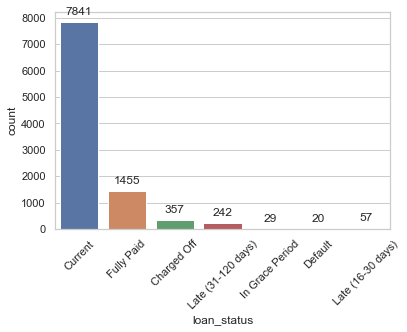

In [225]:
df['loan_status'].value_counts()

import seaborn as sns

sns.set(style="whitegrid")
splot = sns.countplot(x="loan_status",data=df[['loan_status']])
plt.xticks(rotation = 45)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### 2. Split

In [226]:
from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



### baseline prediction
Make a wild guess, all the loan status is current, check the accuracy under such prediction. Our model performance should outweight that at least.

In [227]:
print(y_test.value_counts())
print(y_test.count())
print('-------------------')
print('baseline accuracy: {}'.format(y_test[y_test=='Current'].count()/y_test.count()))


Current               1578
Fully Paid             278
Charged Off             85
Late (31-120 days)      38
Late (16-30 days)       11
In Grace Period          8
Default                  3
Name: loan_status, dtype: int64
2001
-------------------
baseline accuracy: 0.7886056971514243


### 3. select K best, gridSearch 

In [228]:
# using chi-squre to select the top 200 features.
from sklearn.feature_selection import SelectKBest, chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
dftypes = pd.DataFrame(X_train.dtypes.values)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores, dftypes],axis=1)
# featureScores['dftypes'] = dftypes
featureScores.columns = ['Specs','Score','dftypes']  #naming the dataframe columns


print(featureScores.nlargest(50,'Score'))


                           Specs         Score  dftypes
24               last_pymnt_amnt  6.198336e+07  float64
19               total_rec_prncp  2.408946e+07  float64
15                     out_prncp  1.666022e+07  float64
16                 out_prncp_inv  1.665562e+07  float64
17                   total_pymnt  1.632233e+07  float64
18               total_pymnt_inv  1.632132e+07  float64
55               tot_hi_cred_lim  7.516172e+06  float64
29                   tot_cur_bal  5.752376e+06  float64
22                    recoveries  2.757408e+06  float64
7                     annual_inc  1.172282e+06  float64
30              total_rev_hi_lim  1.039638e+06  float64
57                total_bc_limit  7.226930e+05  float64
32                   avg_cur_bal  7.157569e+05  float64
1                      member_id  5.354774e+05  float64
0                             id  5.341724e+05    int64
23       collection_recovery_fee  4.838834e+05  float64
28                  tot_coll_amt  4.581211e+05  

In [229]:
# take the K best score (k = 10, 50 or 100)
take_k = 50
X_train_KBest = X_train[featureScores.nlargest(take_k,'Score')['Specs'].values].copy()
# X_train_KBest

X_test_KBest = X_test[X_train_KBest.columns].copy()
# X_test_KBest


In [230]:
# fast check if taking k feature is sactifactory using default hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(verbose=0, n_estimators=10, n_jobs=-1)

cross_val_score(rfc, X_train_KBest, y_train, cv=5)

array([0.99    , 0.989375, 0.990625, 0.9875  , 0.986875])

#### 3.2 random forest

#### Random Search with Cross Validation
first use random search to narrow down the parameter settings, then use gridsearch to get more combinations

In [231]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 40, 60, 80, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 23, 36, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [232]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(random_state=42, verbose=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                              n_iter = 20, scoring='accuracy', 
                              cv = 5, verbose=3, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
_ = rfc_random.fit(X_train_KBest, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


In [233]:
rfc_random.best_params_

{'n_estimators': 80,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 23,
 'bootstrap': False}

### Evaluation Function

In [234]:
print(rfc_random.best_score_)
print(rfc_random.best_estimator_)


0.99
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=23, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [235]:
result_rfc_random = rfc_random.cv_results_
# result_rfc_random

### Accuracy against training time plot
While best_params_ gives the hyperparameters assocaited with the highest accuracy model, computation efficiency might be also be of interest, especially when the datasets have millions of or billions of records, and/or high diminsionality. So, we plot the accuracy score against time to see if accuracy is more important, or compromise can be made if time is a priority.

In [259]:

#concat two dataframes for better visualization 
df_result_random = pd.concat([pd.DataFrame(result_rfc_random['mean_fit_time']),
                              pd.DataFrame(result_rfc_random['mean_test_score'])],axis=1)

df_result_random.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_random['accuracy_time_ratio'] = df_result_random['mean_test_score']/df_result_random['mean_fit_time']
df_result_random['params'] = result_rfc_random['params']
# df_result_random

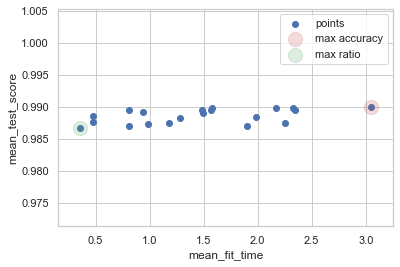

In [237]:
plt.scatter(result_rfc_random['mean_fit_time'], result_rfc_random['mean_test_score'], c='b', label="points")
plt.scatter(result_rfc_random['mean_fit_time'][3], result_rfc_random['mean_test_score'][3], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(result_rfc_random['mean_fit_time'][0], result_rfc_random['mean_test_score'][0], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

In [238]:
print(result_rfc_random['params'][3])
print(result_rfc_random['params'][0])

{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 23, 'bootstrap': False}
{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


### Grid Search with Cross Validation


In [239]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [36, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 10],
    'n_estimators': [10,40]
}
# Create a based model
rfc = RandomForestClassifier(random_state=42, verbose=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 3)


# Fit the random search model
_ = grid_search.fit(X_train_KBest, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   25.8s finished


In [240]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
# print(grid_search.cv_results_)
result_rfc_grid = grid_search.cv_results_

{'bootstrap': False, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40}
-------------------------------------
0.9901249999999999
-------------------------------------
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=36, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
-------------------------------------


In [241]:
#concat two dataframes for better visualization 
df_result_grid = pd.concat([pd.DataFrame(result_rfc_grid['mean_fit_time']),
                              pd.DataFrame(result_rfc_grid['mean_test_score'])],axis=1)

df_result_grid.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_grid['accuracy_time_ratio'] = df_result_grid['mean_test_score']/df_result_grid['mean_fit_time']
df_result_grid['params'] = result_rfc_grid['params']


In [242]:
# Grid search cv result sumary
print("Highest accuracy model is: NO. {}: \n {}".format(df_result_grid['mean_test_score'].idxmax(), 
                                                     df_result_grid['params'][df_result_grid['mean_test_score'].idxmax()]))
print("Highest accuracy-time ratio model is: NO. {}: \n {}".format(df_result_grid['accuracy_time_ratio'].idxmax(), 
                                                     df_result_grid['params'][df_result_grid['accuracy_time_ratio'].idxmax()]))


Highest accuracy model is: NO. 19: 
 {'bootstrap': False, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40}
Highest accuracy-time ratio model is: NO. 0: 
 {'bootstrap': True, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


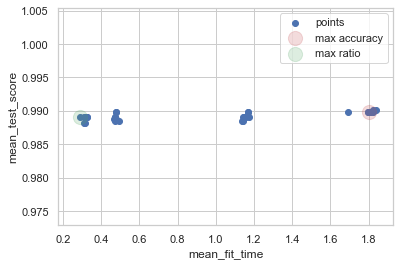

In [243]:
# visualize the cv result
plt.scatter(df_result_grid['mean_fit_time'], df_result_grid['mean_test_score'], c='b', label="points")
plt.scatter(df_result_grid['mean_fit_time'][23], df_result_grid['mean_test_score'][23], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(df_result_grid['mean_fit_time'][0], df_result_grid['mean_test_score'][0], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

### Evaluation on the test set (hold-out data)
Since the dataset is not very huge. We choose the model with hyperparameters give highest accuracy for evaluation.

In [244]:
# Create the final RF classifier

# parameter = {'n_estimators': 40, 
#              'min_samples_split': 2,
#              'min_samples_leaf': 1,
#              'max_features': 'sqrt',
#              'max_depth': 36, 
#              'bootstrap': False}
parameter = df_result_grid['params'][23]

# Create a based model
rfc = RandomForestClassifier(**parameter, random_state=42, verbose=1, n_jobs=-1)
_ = rfc.fit(X_train_KBest, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [258]:
#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred=rfc.predict(X_test_KBest)

print('classification_report')
print(classification_report(y_test,y_pred))
print('----------------------------')
print('accuracy_score')
print(accuracy_score(y_test, y_pred))

classification_report
                    precision    recall  f1-score   support

       Charged Off       1.00      0.98      0.99        85
           Current       0.99      1.00      1.00      1578
           Default       0.75      1.00      0.86         3
        Fully Paid       0.99      1.00      1.00       278
   In Grace Period       0.00      0.00      0.00         8
 Late (16-30 days)       1.00      0.45      0.62        11
Late (31-120 days)       1.00      0.95      0.97        38

          accuracy                           0.99      2001
         macro avg       0.82      0.77      0.78      2001
      weighted avg       0.99      0.99      0.99      2001

----------------------------
accuracy_score
0.9910044977511244


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  40 out of  40 | elapsed:    0.0s finished
C:\Users\kefei\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


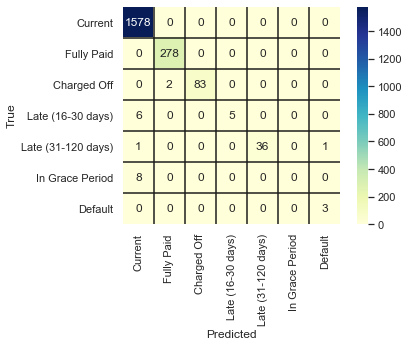

In [257]:
cf_matrix = confusion_matrix(y_test,y_pred, labels=y_test.unique())
X_axis_labels = y_test.unique()
Y_axis_labels = y_test.unique()
ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.hlines(np.arange(1,7), *ax.get_xlim())
ax.vlines(np.arange(1,7), *ax.get_ylim())

In [262]:
y_test.value_counts()

Current               1578
Fully Paid             278
Charged Off             85
Late (31-120 days)      38
Late (16-30 days)       11
In Grace Period          8
Default                  3
Name: loan_status, dtype: int64

### intermediate sumary for random forest model
- Generally speaking, the performance on the test set is not bad, the accuracy is 0.9910.
- GridSearchCV approach helped us to find hyper-parameters that increase the accuracy for 0.01 (or 1%), which is a good news.
- However, for individual categories, i.e. 'Default', 'In Grace Period', 'Late (16-30 days)', the performance is not very satisfactory. This might be due to the fact that the numbers of sub class in our target variable is very unbalanced. The model could fail to capture the underlying mechanics for such labels, since there is not enough data for training.
- To improve performance, especially precision and recall rate on 'Default', 'In Grace Period', 'Late (16-30 days)', we might try adding more data with such lables in the training process.

### remaining work
- perform gridserchCV using Decision tree model, using the same features (i.e. top 50 selectKBest) (part II)
- using PCA, then repeat the process again. (part III)

# part II decision tree

### recall
- We will use the same dataset, same features, same training and test data as random forest model
- Also, recall the baseline accuracy is 0.7886
- So, we will start from decision tree modeling

In [265]:
# fast check if taking k feature is sactifactory using default hyperparameters
from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()

cross_val_score(dtc, X_train_KBest, y_train, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


array([0.980625, 0.97625 , 0.983125, 0.9825  , 0.98375 ])

### Grid Search with Cross Validation
- Decision tree model is less complex than random forest, and also faster
- So, we jump into grid search CV for decision tree's hyper parameter search.

In [278]:
# from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

    
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20, 50, 100, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': range(1, 10)
    
}
# Create a based model
dtc = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search.fit(X_train_KBest, y_train)

In [268]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
# print(grid_search.cv_results_)
result_dtc_grid = grid_search.cv_results_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
-------------------------------------
0.9873749999999999
-------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-------------------------------------


In [270]:
#concat two dataframes for better visualization 
df_result_grid2 = pd.concat([pd.DataFrame(result_dtc_grid['mean_fit_time']),
                              pd.DataFrame(result_dtc_grid['mean_test_score'])],axis=1)

df_result_grid2.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_grid2['accuracy_time_ratio'] = df_result_grid2['mean_test_score']/df_result_grid2['mean_fit_time']
df_result_grid2['params'] = result_dtc_grid['params']


In [271]:
# Grid search cv result sumary
print("Highest accuracy model is: NO. {}: \n {}".format(df_result_grid2['mean_test_score'].idxmax(), 
                                                     df_result_grid2['params'][df_result_grid2['mean_test_score'].idxmax()]))
print("Highest accuracy-time ratio model is: NO. {}: \n {}".format(df_result_grid2['accuracy_time_ratio'].idxmax(), 
                                                     df_result_grid2['params'][df_result_grid2['accuracy_time_ratio'].idxmax()]))


Highest accuracy model is: NO. 104: 
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
Highest accuracy-time ratio model is: NO. 105: 
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}


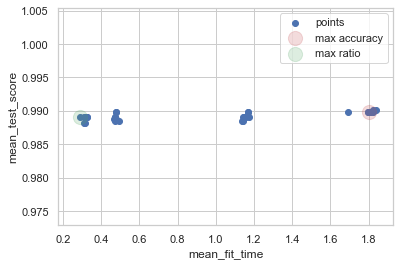

In [243]:
# visualize the cv result
plt.scatter(df_result_grid['mean_fit_time'], df_result_grid['mean_test_score'], c='b', label="points")
plt.scatter(df_result_grid['mean_fit_time'][23], df_result_grid['mean_test_score'][23], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(df_result_grid['mean_fit_time'][0], df_result_grid['mean_test_score'][0], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

### Evaluation on the test set (hold-out data)
Since the dataset is not very huge. We choose the model with hyperparameters give highest accuracy for evaluation.

In [275]:
# Create the final RF classifier

# parameter = {'n_estimators': 40, 
#              'min_samples_split': 2,
#              'min_samples_leaf': 1,
#              'max_features': 'sqrt',
#              'max_depth': 36, 
#              'bootstrap': False}
parameter2 = df_result_grid2['params'][104]

# Create a based model
dtc = RandomForestClassifier(**parameter2, random_state=42, verbose=0, n_jobs=-1)
_ = dtc.fit(X_train_KBest, y_train)


In [277]:
#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred2=dtc.predict(X_test_KBest)

print('classification_report')
print(classification_report(y_test,y_pred2, zero_division=0))
print('----------------------------')
print('accuracy_score')
print(accuracy_score(y_test, y_pred2))

classification_report
                    precision    recall  f1-score   support

       Charged Off       1.00      0.98      0.99        85
           Current       0.99      1.00      0.99      1578
           Default       0.75      1.00      0.86         3
        Fully Paid       0.99      1.00      1.00       278
   In Grace Period       0.00      0.00      0.00         8
 Late (16-30 days)       0.00      0.00      0.00        11
Late (31-120 days)       1.00      0.95      0.97        38

          accuracy                           0.99      2001
         macro avg       0.68      0.70      0.69      2001
      weighted avg       0.98      0.99      0.98      2001

----------------------------
accuracy_score
0.9885057471264368


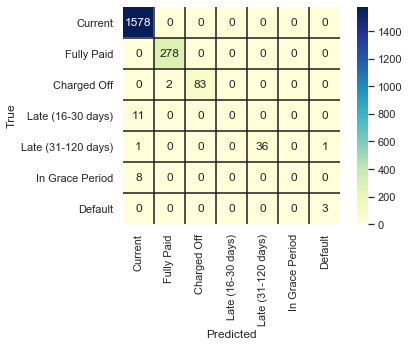

In [274]:
cf_matrix = confusion_matrix(y_test,y_pred2, labels=y_test.unique())
X_axis_labels = y_test.unique()
Y_axis_labels = y_test.unique()
ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.hlines(np.arange(1,7), *ax.get_xlim())
ax.vlines(np.arange(1,7), *ax.get_ylim())

### intermediate sumary
- The decision tree model has lower accuracy rate compare to random forest model. (i.e. 0.9885 vs. 0.9910)
- However, decision tree is much faster than random forest.
- By looking at the classification_report and confustion matrix, we can find that, decision tree also suffer from predicting rare-appared instances, i.e. 'Default', 'In Grace Period', 'Late (16-30 days)'. 
- The gridsearch approach also provide hyper-parameters that improve accuracy on the test data.

# part III
feature enineering using PCA, then perform random forest and decision tree classification again.

ref: https://www.codementor.io/@divyeshaegis/when-to-use-pca-before-or-after-a-train-test-split-vxdrlu6ci

### recall
- We will use the same dataset, same features, same training and test data as random forest model
- Also, recall the baseline accuracy is 0.7886
- So, we will start from feature engineering (PCA)

In [443]:
# for convenience repeat here
# from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### It is widely accepted that PCA does not work well on categorical / binary type of data, so we only perform PCA on continous data. For the rest it, we will use selectKBest

In [444]:
# 'object' type data info
pca_list = []
for col in X_train.columns:
#     print(X_train[col].nunique())
    if X_train[col].nunique() > 2:
        pca_list.append(col)

In [445]:
X_train_continous = X_train.loc[:,pca_list]
X_test_continous = X_test.loc[:,pca_list]
# X_train_continous

In [446]:
encoding_list = [item for item in list(X_train.columns) if item not in pca_list]
X_train_encoding = X_train.loc[:,encoding_list]
X_test_encoding = X_test.loc[:,encoding_list]
# X_train_encoding

In [447]:
# perform standard scalar normalization to normalize our feature set
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_stdscaler = sc.fit_transform(X_train_continous)
X_test_stdscaler = sc.transform(X_test_continous)

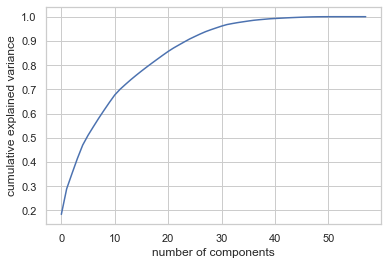

In [472]:
# Applying PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_stdscaler)

# plot
explained_variance = pca.explained_variance_ratio_
explained_variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [473]:
pca = PCA(n_components=30)

X_train_continous = pca.fit_transform(X_train_stdscaler)
X_test_continous = pca.transform(X_test_stdscaler)

In [474]:
# X_train_continous.shape

#### selectKbest

In [475]:
# using chi-squre to select the top 200 features.
# from sklearn.feature_selection import SelectKBest, chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_train_encoding,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_encoding.columns)
dftypes = pd.DataFrame(X_train_encoding.dtypes.values)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores, dftypes],axis=1)
# featureScores['dftypes'] = dftypes
featureScores.columns = ['Specs','Score','dftypes']  #naming the dataframe columns


# print(featureScores.nlargest(50,'Score'))


In [476]:
# take the K best score (k = 20)
take_k = 20
X_train_KBest = X_train[featureScores.nlargest(take_k,'Score')['Specs'].values].copy()
# X_train_KBest

X_test_KBest = X_test[X_train_KBest.columns].copy()
# X_test_KBest


In [477]:
pd.DataFrame(X_train_continous)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6.428269,2.682757,2.250459,-9.312073,2.971323,0.415720,-1.793187,-0.414958,-0.453026,-0.175107,...,-0.348739,-0.276006,-0.092312,-0.837216,0.580908,0.826411,0.066176,1.204172,0.065714,-0.053473
1,-1.391119,0.067291,-2.080221,-0.379659,-1.292834,-0.972226,0.075933,0.057728,-0.057285,0.752842,...,-0.269484,0.259173,0.165292,0.457791,-0.619369,-0.395139,0.674966,0.759033,0.029362,0.820373
2,4.320306,-5.650859,-1.901587,-0.833684,2.384688,0.281164,-0.046728,0.101988,0.229895,-0.040158,...,0.365414,0.145728,0.480504,-1.067460,-0.087104,0.057085,-0.470297,-0.251342,0.698842,-0.580553
3,2.928293,1.632387,4.603475,-4.587685,-0.836110,1.631155,-0.324822,-0.197626,-0.342593,-0.774271,...,0.571436,1.327779,-1.142102,1.405676,0.053132,-0.132316,0.591607,1.315818,-0.753445,0.945706
4,-1.138958,-1.249281,-0.490809,-0.088124,1.537640,0.867687,0.470346,0.068450,-0.063009,-0.312089,...,0.188648,-0.323747,0.474021,-0.757527,-0.177819,-0.181980,0.002788,-0.083526,-0.596069,-0.598217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.630008,-2.359242,-2.079336,-0.958393,1.207036,0.751682,0.969271,-0.037004,-0.377921,0.011415,...,-0.143468,-1.038568,3.001965,-0.510445,-1.187961,-0.425068,-1.101103,-1.160065,0.891376,0.302592
7996,-1.707168,-1.098791,1.328928,-2.665047,-0.846321,0.374111,-1.220293,-0.334198,0.011252,-0.186074,...,-0.091641,-0.034041,-0.076948,0.562017,-0.456544,0.736344,-0.336560,0.452452,-0.411545,0.046760
7997,-1.042150,0.763288,2.602068,-1.840042,1.778293,-0.919255,-1.283693,-0.344463,-0.429571,-0.299508,...,0.397999,0.757451,-0.209372,0.027293,0.881446,-0.276007,0.333717,0.803618,0.170651,-0.234358
7998,7.238560,-1.005207,-3.600543,0.788218,0.171086,0.809019,-1.355757,-0.205063,0.021189,-0.166346,...,0.048265,-0.088403,-0.388746,-1.809602,1.316712,-1.394212,0.675674,0.774860,-0.325662,0.134823


In [478]:
X_train_KBest.values

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [479]:
X_train_pca = pd.concat([pd.DataFrame(X_train_continous), 
                         pd.DataFrame(X_train_KBest.values)],axis=1)

X_test_pca = pd.concat([pd.DataFrame(X_test_continous), 
                         pd.DataFrame(X_test_KBest.values)],axis=1)


X_train_pca

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
0,6.428269,2.682757,2.250459,-9.312073,2.971323,0.415720,-1.793187,-0.414958,-0.453026,-0.175107,...,0,0,0,0,0,0,0,0,0,1
1,-1.391119,0.067291,-2.080221,-0.379659,-1.292834,-0.972226,0.075933,0.057728,-0.057285,0.752842,...,0,0,0,1,0,0,0,0,0,0
2,4.320306,-5.650859,-1.901587,-0.833684,2.384688,0.281164,-0.046728,0.101988,0.229895,-0.040158,...,0,0,0,1,0,0,0,0,0,0
3,2.928293,1.632387,4.603475,-4.587685,-0.836110,1.631155,-0.324822,-0.197626,-0.342593,-0.774271,...,0,0,1,0,0,0,0,0,0,0
4,-1.138958,-1.249281,-0.490809,-0.088124,1.537640,0.867687,0.470346,0.068450,-0.063009,-0.312089,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.630008,-2.359242,-2.079336,-0.958393,1.207036,0.751682,0.969271,-0.037004,-0.377921,0.011415,...,1,0,0,1,0,0,0,0,0,0
7996,-1.707168,-1.098791,1.328928,-2.665047,-0.846321,0.374111,-1.220293,-0.334198,0.011252,-0.186074,...,0,0,0,0,0,0,0,0,0,0
7997,-1.042150,0.763288,2.602068,-1.840042,1.778293,-0.919255,-1.283693,-0.344463,-0.429571,-0.299508,...,0,0,1,0,0,0,0,0,1,0
7998,7.238560,-1.005207,-3.600543,0.788218,0.171086,0.809019,-1.355757,-0.205063,0.021189,-0.166346,...,0,0,0,1,0,0,0,0,0,0


In [480]:
# fast check if taking k feature is sactifactory using default hyperparameters
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

cross_val_score(rfc, X_train_pca, y_train, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


array([0.9775  , 0.978125, 0.985   , 0.9825  , 0.979375])

### Grid Search with Cross Validation
- Decision tree model is less complex than random forest, and also faster
- So, we jump into grid search CV for decision tree's hyper parameter search.

In [481]:
# from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

    
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20, 50, 100, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': range(1, 10)
    
}
# Create a based model
dtc = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search.fit(X_train_KBest, y_train)

In [482]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
# print(grid_search.cv_results_)
result_dtc_grid = grid_search.cv_results_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7}
-------------------------------------
0.96225
-------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-------------------------------------


In [483]:
#concat two dataframes for better visualization 
df_result_grid2 = pd.concat([pd.DataFrame(result_dtc_grid['mean_fit_time']),
                              pd.DataFrame(result_dtc_grid['mean_test_score'])],axis=1)

df_result_grid2.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_grid2['accuracy_time_ratio'] = df_result_grid2['mean_test_score']/df_result_grid2['mean_fit_time']
df_result_grid2['params'] = result_dtc_grid['params']


In [484]:
# Grid search cv result sumary
print("Highest accuracy model is: NO. {}: \n {}".format(df_result_grid2['mean_test_score'].idxmax(), 
                                                     df_result_grid2['params'][df_result_grid2['mean_test_score'].idxmax()]))
print("Highest accuracy-time ratio model is: NO. {}: \n {}".format(df_result_grid2['accuracy_time_ratio'].idxmax(), 
                                                     df_result_grid2['params'][df_result_grid2['accuracy_time_ratio'].idxmax()]))


Highest accuracy model is: NO. 114: 
 {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7}
Highest accuracy-time ratio model is: NO. 6: 
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 7}


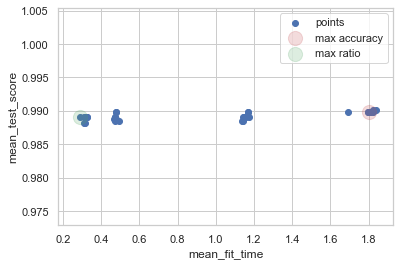

In [485]:
# visualize the cv result
plt.scatter(df_result_grid['mean_fit_time'], df_result_grid['mean_test_score'], c='b', label="points")
plt.scatter(df_result_grid['mean_fit_time'][23], df_result_grid['mean_test_score'][23], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(df_result_grid['mean_fit_time'][0], df_result_grid['mean_test_score'][0], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

### Evaluation on the test set (hold-out data)
Since the dataset is not very huge. We choose the model with hyperparameters give highest accuracy for evaluation.

In [489]:
# Create the final RF classifier

# parameter = {'n_estimators': 40, 
#              'min_samples_split': 2,
#              'min_samples_leaf': 1,
#              'max_features': 'sqrt',
#              'max_depth': 36, 
#              'bootstrap': False}
parameter2 = df_result_grid2['params'][df_result_grid2['mean_test_score'].idxmax()]

# Create a based model
dtc = RandomForestClassifier(**parameter2, random_state=42, verbose=0, n_jobs=-1)
_ = dtc.fit(X_train_KBest, y_train)


In [490]:
#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred2=dtc.predict(X_test_KBest)

print('classification_report')
print(classification_report(y_test,y_pred2, zero_division=0))
print('----------------------------')
print('accuracy_score')
print(accuracy_score(y_test, y_pred2))

classification_report
                    precision    recall  f1-score   support

       Charged Off       0.72      0.72      0.72        85
           Current       0.99      1.00      0.99      1578
           Default       1.00      1.00      1.00         3
        Fully Paid       0.91      0.91      0.91       278
   In Grace Period       0.00      0.00      0.00         8
 Late (16-30 days)       0.00      0.00      0.00        11
Late (31-120 days)       1.00      0.97      0.99        38

          accuracy                           0.97      2001
         macro avg       0.66      0.66      0.66      2001
      weighted avg       0.96      0.97      0.96      2001

----------------------------
accuracy_score
0.9655172413793104


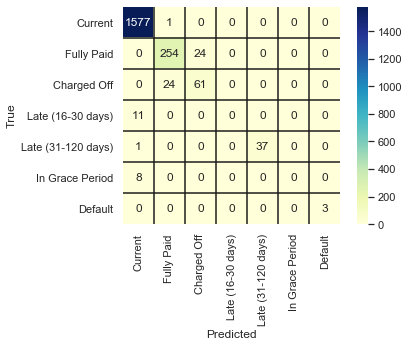

In [491]:
cf_matrix = confusion_matrix(y_test,y_pred2, labels=y_test.unique())
X_axis_labels = y_test.unique()
Y_axis_labels = y_test.unique()
ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.hlines(np.arange(1,7), *ax.get_xlim())
ax.vlines(np.arange(1,7), *ax.get_ylim())